Daftar Kota dan Indeksnya:
Indeks 0: Jakarta
Indeks 1: Bandung
Indeks 2: Semarang
Indeks 3: Yogyakarta
Indeks 4: Surabaya
Indeks 5: Serang
------------------------------

--- HASIL OPTIMASI ACO ---
Rute Terpendek (indeks kota): [np.int64(2), np.int64(0), np.int64(5), np.int64(1), np.int64(3), np.int64(4), np.int64(2)]
Rute Terpendek (nama kota): Semarang -> Jakarta -> Serang -> Bandung -> Yogyakarta -> Surabaya -> Semarang
Jarak Total Tur Tertutup: 1515.29 KM
------------------------------


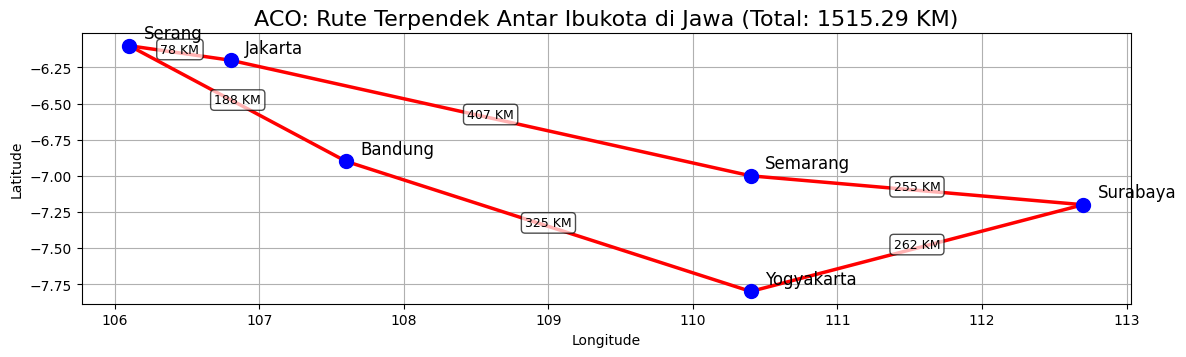

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2

# 1. DATA KOTA DAN KOORDINAT
# ==============================================================================
# Data kota ibukota provinsi Pulau Jawa
city_names = ["Jakarta", "Bandung", "Semarang", "Yogyakarta", "Surabaya", "Serang"]
# Koordinat dalam format (latitude, longitude) dalam derajat
coordinates = np.array([
    [-6.2, 106.8],    # Jakarta
    [-6.9, 107.6],    # Bandung
    [-7.0, 110.4],    # Semarang
    [-7.8, 110.4],    # Yogyakarta
    [-7.2, 112.7],    # Surabaya
    [-6.1, 106.1],    # Serang
])

# 2. FUNGSI PERHITUNGAN JARAK (HAVERSINE)
# ==============================================================================
def haversine_distance(coord1, coord2):
    """Menghitung jarak antara dua titik koordinat geografis menggunakan rumus Haversine."""
    R = 6371  # Radius bumi dalam kilometer

    lat1, lon1 = radians(coord1[0]), radians(coord1[1])
    lat2, lon2 = radians(coord2[0]), radians(coord2[1])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

def calculate_distances_km(coords):
    """Membuat matriks jarak antar semua kota."""
    n = len(coords)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                dist_matrix[i, j] = haversine_distance(coords[i], coords[j])
    return dist_matrix

# Hitung matriks jarak dalam kilometer
distances_km = calculate_distances_km(coordinates)


# 3. CLASS ALGORITMA KOLONI SEMUT (ACO) YANG SUDAH DIREVISI
# ==============================================================================
class AntColonyOptimizer:
    def __init__(self, distances, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
        self.distances = distances
        self.pheromone = np.ones(self.distances.shape) / len(distances)
        self.all_inds = range(len(distances))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta

    def run(self):
        shortest_path = None
        best_cost = float('inf')

        for i in range(self.n_iterations):
            # Hasilkan sekumpulan rute tertutup untuk semua semut
            paths = self.generate_paths()

            # Perbarui feromon berdasarkan rute-rute terbaik dari iterasi ini
            self.spread_pheromone(paths)

            # Cari rute terbaik yang ditemukan di iterasi saat ini
            for path in paths:
                cost = self.path_cost(path)
                # Jika rute saat ini lebih baik dari rute terbaik sepanjang masa, perbarui
                if cost < best_cost:
                    best_cost = cost
                    shortest_path = path

            # Lakukan evaporasi (penguapan) feromon di semua jalur
            self.pheromone *= self.decay

        return shortest_path, best_cost

    def generate_paths(self):
        """Membuat rute untuk setiap semut. Rute ini adalah tur tertutup."""
        paths = []
        for i in range(self.n_ants):
            # Setiap semut memulai dari kota awal yang acak
            start_node = np.random.choice(self.all_inds)
            path = [start_node]
            visited = {start_node}

            # Bangun rute dengan mengunjungi semua kota yang belum dikunjungi
            while len(path) < len(self.distances):
                move = self.probabilistic_next_move(path, visited)
                path.append(move)
                visited.add(move)

            # REVISI KUNCI: Menambahkan kota awal ke akhir rute untuk membuat tur tertutup
            path.append(path[0])
            paths.append(path)

        return paths

    def probabilistic_next_move(self, current_path, visited):
        """Memilih kota berikutnya berdasarkan probabilitas dari feromon dan jarak."""
        last_node = current_path[-1]
        pheromone_values = np.copy(self.pheromone[last_node])

        # Abaikan kota yang sudah dikunjungi dengan mengatur feromonnya menjadi 0
        for node_idx in visited:
            pheromone_values[node_idx] = 0

        # Nilai heuristik (1/jarak). Hindari pembagian dengan nol.
        with np.errstate(divide='ignore', invalid='ignore'):
            heuristic_values = 1.0 / self.distances[last_node]
        heuristic_values[self.distances[last_node] == 0] = 0

        # Hitung probabilitas
        probabilities = (pheromone_values ** self.alpha) * (heuristic_values ** self.beta)

        sum_probs = np.sum(probabilities)
        if sum_probs == 0:
            # Jika tidak ada jalur yang mungkin, pilih acak dari yang belum dikunjungi
            # (jarang terjadi pada graf yang terhubung sepenuhnya)
            unvisited_nodes = [i for i in self.all_inds if i not in visited]
            return np.random.choice(unvisited_nodes)

        # Normalisasi probabilitas dan pilih kota berikutnya
        normalized_probabilities = probabilities / sum_probs
        next_node = np.random.choice(self.all_inds, p=normalized_probabilities)
        return next_node

    def spread_pheromone(self, paths):
        """Memperbarui jejak feromon berdasarkan rute terbaik dari satu iterasi."""
        # Urutkan rute berdasarkan biayanya (jarak terpendek)
        sorted_paths = sorted(paths, key=lambda path: self.path_cost(path))

        # Hanya semut-semut terbaik (n_best) yang boleh meninggalkan feromon
        for path in sorted_paths[:self.n_best]:
            cost = self.path_cost(path)
            pheromone_to_add = 1.0 / cost  # Semakin pendek rute, semakin banyak feromon

            # Tambahkan feromon pada setiap segmen dari tur tertutup
            for i in range(len(self.distances)):
                start_node = path[i]
                end_node = path[i+1]
                self.pheromone[start_node, end_node] += pheromone_to_add
                # Untuk graf simetris (jarak A->B sama dengan B->A)
                self.pheromone[end_node, start_node] += pheromone_to_add

    def path_cost(self, path):
        """Menghitung total jarak dari sebuah rute tertutup."""
        total_cost = 0
        # Loop berjalan sepanjang rute (N+1 kota), menghitung N segmen
        for i in range(len(path) - 1):
            start_node, end_node = path[i], path[i+1]
            total_cost += self.distances[start_node, end_node]
        return total_cost

# 4. MENJALANKAN ALGORITMA DAN MENAMPILKAN HASIL
# ==============================================================================
# Inisialisasi parameter dan membuat objek ACO
aco = AntColonyOptimizer(distances_km, n_ants=30, n_best=10, n_iterations=200, decay=0.95, alpha=1, beta=2)

# Jalankan algoritma
shortest_closed_path, closed_path_cost = aco.run()

# Menampilkan daftar kota dan indeksnya
print("Daftar Kota dan Indeksnya:")
for index, name in enumerate(city_names):
    print(f"Indeks {index}: {name}")
print("-" * 30)

# Menampilkan hasil akhir
print("\n--- HASIL OPTIMASI ACO ---")
print(f"Rute Terpendek (indeks kota): {shortest_closed_path}")
if shortest_closed_path is not None:
    shortest_path_names = [city_names[i] for i in shortest_closed_path]
    print(f"Rute Terpendek (nama kota): {' -> '.join(shortest_path_names)}")
print(f"Jarak Total Tur Tertutup: {closed_path_cost:.2f} KM")
print("-" * 30)


# 5. VISUALISASI HASIL
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 8))

# Plot rute terbaik (garis merah tebal)
if shortest_closed_path is not None:
    # Loop sekarang berjalan sepanjang tur tertutup (N+1 kota), menggambar N segmen
    for i in range(len(shortest_closed_path) - 1):
        start_city_idx = shortest_closed_path[i]
        end_city_idx = shortest_closed_path[i+1]

        # Gambar garis antar kota
        ax.plot([coordinates[start_city_idx, 1], coordinates[end_city_idx, 1]],  # Longitude
                [coordinates[start_city_idx, 0], coordinates[end_city_idx, 0]],  # Latitude
                color='red', linewidth=2.5, zorder=3)

        # Tampilkan jarak pada segmen
        mid_x = (coordinates[start_city_idx, 1] + coordinates[end_city_idx, 1]) / 2
        mid_y = (coordinates[start_city_idx, 0] + coordinates[end_city_idx, 0]) / 2
        segment_distance = distances_km[start_city_idx, end_city_idx]
        ax.text(mid_x, mid_y, f"{segment_distance:.0f} KM", color='black', fontsize=9, ha='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

# Plot titik-titik kota
for i, (lat, lon) in enumerate(coordinates):
    ax.scatter(lon, lat, color='blue', s=100, zorder=5, label=city_names[i] if i == 0 else "")
    ax.text(lon + 0.1, lat + 0.05, city_names[i], fontsize=12)

# Pengaturan Judul dan Label Grafik
if shortest_closed_path is not None:
    ax.set_title(f"ACO: Rute Terpendek Antar Ibukota di Jawa (Total: {closed_path_cost:.2f} KM)", fontsize=16)
else:
    ax.set_title("ACO: Rute Terpendek Tidak Ditemukan", fontsize=16)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True)
ax.set_aspect('equal', adjustable='box') # Membuat skala sumbu X dan Y sama
plt.tight_layout()
plt.show()